## Importing necessary Libraries

In [2]:
# Importing necessary libraries
import nltk
nltk.download('punkt')
nltk.download('vader_lexicon')

# Import other necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import os
import re
import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\su1qt\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\su1qt\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [11]:
# Define the paths
scripts_raw_path = r'C:\Users\su1qt\Significant Projects\Honors Research\data\scripts_raw'  # Adjust this path accordingly
dialogues_path = r'C:\Users\su1qt\Significant Projects\Honors Research\data\dialogues\Princess_and_the_Frog'      # Output directory
output_viz_path = r'C:\Users\su1qt\Significant Projects\Honors Research\outputs\Princess_and_the_Frog'

# Ensure the output directories exist
if not os.path.exists(dialogues_path):
    os.makedirs(dialogues_path)
if not os.path.exists(output_viz_path):
    os.makedirs(output_viz_path)

# Define the path to the Princess and the Frog script
script_filename = 'the_princess_and_the_frog_script.txt'
script_path = os.path.join(scripts_raw_path, script_filename)

# Verify that the script file exists
if not os.path.isfile(script_path):
    print(f"Error: The file {script_path} does not exist.")
    print("Please ensure the script file is placed in the specified directory.")
else:
    print(f"Processing script: {script_path}")


Processing script: C:\Users\su1qt\Significant Projects\Honors Research\data\scripts_raw\the_princess_and_the_frog_script.txt


## Dialogue Extraction

In [13]:
# Define regex patterns
character_pattern = re.compile(r'^[A-Z][A-Z\s\-#\d]*:$')
dialogue_pattern = re.compile(r'^([A-Za-z][A-Za-z\s\-\d#]*)(?:\s*\[.*?\])?:\s*(.*)')
scene_pattern = re.compile(r'^\[.*\]$')

## Dialogue Extraction Function
def extract_dialogues(script_path):
    dialogues = []
    with open(script_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
    
    current_dialogue = None
    
    for line_number, line in enumerate(lines, start=1):
        line = line.strip()
        
        # Skip empty lines
        if not line:
            continue
        
        # Skip scene descriptions that are in square brackets and do not have dialogue
        if line.startswith('[') and line.endswith(']'):
            continue
        
        # Try to match dialogue lines
        match = re.match(r'^([A-Za-z][A-Za-z\s\-\d#]*)(?:\s*\[.*?\])?:\s*(.*)', line)
        if match:
            character = match.group(1).strip().upper()
            dialogue = match.group(2)
            
            # Remove any stage directions within the dialogue
            dialogue = re.sub(r'\[.*?\]|\(.*?\)', '', dialogue).strip()
            
            if dialogue:
                # Handle multiple characters (e.g., 'TIANA and NAVREEN')
                characters = [char.strip() for char in re.split(r'\band\b|&', character)]
                for char in characters:
                    if char:  # Ensure it's not empty
                        dialogues.append({
                            'Character': char.title(),  # Convert to title case
                            'Dialogue': dialogue
                        })
                current_dialogue = None
            else:
                current_dialogue = {
                    'Character': character.title(),
                    'Dialogue': ''
                }
        else:
            # If current_dialogue is not None, append this line to it
            if current_dialogue is not None:
                # Remove any stage directions within the line
                dialogue_line = re.sub(r'\[.*?\]|\(.*?\)', '', line).strip()
                if dialogue_line:
                    current_dialogue['Dialogue'] += ' ' + dialogue_line
            else:
                # Maybe it's a continuation of the previous dialogue
                if dialogues:
                    last_dialogue = dialogues[-1]
                    dialogue_line = re.sub(r'\[.*?\]|\(.*?\)', '', line).strip()
                    if dialogue_line:
                        last_dialogue['Dialogue'] += ' ' + dialogue_line
    
    # Debug: Print the number of dialogues extracted
    print(f"Extracted {len(dialogues)} dialogues from the script.")
    
    return dialogues


## Creating DataFrame

In [23]:

# Extract dialogues from the script
if os.path.isfile(script_path):
    princess_dialogues = extract_dialogues(script_path)
    
    # Debug: Print the number of dialogues extracted
    print(f"Number of dialogues extracted: {len(princess_dialogues)}")
    
    # Debug: Print the first few dialogues
    print("First few dialogues extracted:")
    for dialogue in princess_dialogues[:5]:
        print(dialogue)
    
    # Add film title to each dialogue entry
    for dialogue in princess_dialogues:
        if dialogue['Character'].lower() in ['charlotte', 'charlotte la bouff']:
            dialogue['Character'] = 'Charlotte'
        dialogue['Film Title'] = 'The Princess and the Frog'
    
    # Create a DataFrame
    df_princess_dialogues = pd.DataFrame(princess_dialogues)
    
    # Debug: Print DataFrame columns
    print("DataFrame columns:", df_princess_dialogues.columns.tolist())
    
    # Rearrange columns if they exist
    expected_columns = ['Film Title', 'Character', 'Dialogue']
    existing_columns = df_princess_dialogues.columns.tolist()
    columns_to_select = [col for col in expected_columns if col in existing_columns]
    
    if columns_to_select:
        df_princess_dialogues = df_princess_dialogues[columns_to_select]
    else:
        print("Expected columns are not in the DataFrame.")
        print("Available columns:", existing_columns)
    
    # Remove empty dialogues
    df_princess_dialogues = df_princess_dialogues[df_princess_dialogues['Dialogue'] != '']
    
    # Reset index
    df_princess_dialogues.reset_index(drop=True, inplace=True)
    
    # Save to CSV
    output_file = os.path.join(dialogues_path, 'princess_and_the_frog_dialogues.csv')
    df_princess_dialogues.to_csv(output_file, index=False)
    
    print(f"Extracted dialogues saved to {output_file}")
else:
    print(f"Cannot find the script file at {script_path}. Please check the file path.")


Extracted 469 dialogues from the script.
Number of dialogues extracted: 469
First few dialogues extracted:
{'Character': 'Eudora', 'Dialogue': 'Just in that moment, the ugly little frog looked up with his sad, round eyes and pleaded: "Oh, please, dear princess, Only a kiss from you can break this terrible spell, that was inflicted on me by a wicked witch."'}
{'Character': 'Charlotte La Bouff', 'Dialogue': 'There comes my favorite part.'}
{'Character': 'Eudora', 'Dialogue': 'And the beautiful princess was so moved by his desperate plea, that she stooped down, picked up the slippery creature, leaned forward, raised him to her lips, and kissed that little frog. Than the frog was transformed into a handsome prince. They were married and lived happily ever after. The end.'}
{'Character': 'Charlotte', 'Dialogue': 'Yay! Read it again, read it again!'}
{'Character': 'Eudora', 'Dialogue': 'Sorry Charlotte, it’s time for us to be headin’ home. Say good night, Tiana.'}
DataFrame columns: ['Charac

## Annotate Scripts with Character Metadata

In [25]:
## Annotate Scripts with Character Metadata
# Load the dialogues DataFrame
dialogues_df = pd.read_csv(os.path.join(dialogues_path, 'princess_and_the_frog_dialogues.csv'))

# Get a list of unique characters
unique_characters = dialogues_df['Character'].unique()

print("List of unique characters:")
for character in unique_characters:
    print(character)


List of unique characters:
Eudora
Charlotte
Tiana
Eurora
Eli Big Daddy La Bouff
Big Daddy
James
Buford
Lawrence
Naveen
Travis
Dog
Alligator
Louis
Both
Lauis
Facilier
Lawerence
Lous
Ray
Randy
Reggie
Darnell
Navene
Mama Odie
Butterfly
Lawremce
Masks
Shrunken Heads


## Character Metadata Dictionary

In [26]:
## Character MetaData Dictionary
character_metadata = {
    'Eudora': {
        'Gender': 'Female',
        'Race/Ethnicity': 'Middle Eastern',
        'Culture': 'New Orleans',
        'Role': 'Supporting',
        'Marginalized': False,  # As a business owner, Eudora holds significant social status
        'POC': True
    },
    'Charlotte': {
        'Gender': 'Female',
        'Race/Ethnicity': 'Caucasian',
        'Culture': 'New Orleans',
        'Role': 'Protagonist',
        'Marginalized': False,  # As royalty, she holds significant social status
        'POC': False
    },
    'Tiana': {
        'Gender': 'Female',
        'Race/Ethnicity': 'African American',
        'Culture': 'New Orleans',
        'Role': 'Protagonist',
        'Marginalized': True,  # Aspiring restaurateur from a hardworking background
        'POC': True
    },
    'Prince Naveen': {
        'Gender': 'Male',
        'Race/Ethnicity': 'Middle Eastern',
        'Culture': 'Maldonia',
        'Role': 'Protagonist',
        'Marginalized': False,  # Royalty with wealth
        'POC': True
    },
    'Big Daddy': {
        'Gender': 'Male',
        'Race/Ethnicity': 'Caucasian',
        'Culture': 'New Orleans',
        'Role': 'Antagonist',
        'Marginalized': False,  # Wealthy and powerful
        'POC': False
    },
    'Lawrence': {
        'Gender': 'Male',
        'Race/Ethnicity': 'Caucasian',
        'Culture': 'New Orleans',
        'Role': 'Antagonist',
        'Marginalized': False,  # As a servant, he might have lower social status but not necessarily marginalized in the context
        'POC': False
    },
    'Dr. Facilier': {
        'Gender': 'Male',
        'Race/Ethnicity': 'African American',
        'Culture': 'New Orleans',
        'Role': 'Antagonist',
        'Marginalized': False,  # Holds significant power through voodoo magic
        'POC': True
    },
    'Louis': {
        'Gender': 'Male',
        'Race/Ethnicity': 'African American',
        'Culture': 'New Orleans',
        'Role': 'Supporting',
        'Marginalized': False,  # As a jazz musician, he is celebrated
        'POC': True
    },
    'Ray': {
        'Gender': 'Male',
        'Race/Ethnicity': 'African American',
        'Culture': 'New Orleans',
        'Role': 'Supporting',
        'Marginalized': False,  # Part of a supportive community
        'POC': True
    },
    'Mama Odie': {
        'Gender': 'Female',
        'Race/Ethnicity': 'African American',
        'Culture': 'New Orleans',
        'Role': 'Supporting',
        'Marginalized': False,  # As a respected voodoo priestess, she holds significant social status
        'POC': True
    },
    # Add more characters as needed
}


## Merging Metadata with Dialogues

In [31]:
# Define the characters to keep for analysis
characters_to_keep = [
    'Eudora',
    'Charlotte',
    'Tiana',
    'Prince Naveen',
    'Big Daddy',
    'Lawrence',
    'Dr. Facilier',
    'Louis',
    'Ray',
    'Mama Odie'
    # Add more key characters as needed
]

# Filter the DataFrame to include only the characters to keep
filtered_dialogues_df = annotated_dialogues_df[annotated_dialogues_df['Character'].isin(characters_to_keep)]

# Preview the filtered DataFrame
print("\nFiltered Dialogues DataFrame:")
filtered_dialogues_df.head()


Filtered Dialogues DataFrame:


,Film Title,Character,Dialogue,Gender_x,Race/Ethnicity_x,Culture_x,Role_x,Marginalized_x,POC_x,Gender_y,Race/Ethnicity_y,Culture_y,Role_y,Marginalized_y,POC_y
0,The Princess and the Frog,Eudora,"Just in that moment, the ugly little frog look...",Female,Middle Eastern,New Orleans,Supporting,False,True,Female,Middle Eastern,New Orleans,Supporting,False,True
2,The Princess and the Frog,Eudora,And the beautiful princess was so moved by his...,Female,Middle Eastern,New Orleans,Supporting,False,True,Female,Middle Eastern,New Orleans,Supporting,False,True
3,The Princess and the Frog,Eudora,"Sorry Charlotte, it’s time for us to be headin...",Female,Middle Eastern,New Orleans,Supporting,False,True,Female,Middle Eastern,New Orleans,Supporting,False,True
4,The Princess and the Frog,Tiana,"There is no way, in this whole wide world I wo...",Female,African American,New Orleans,Protagonist,True,True,Female,African American,New Orleans,Protagonist,True,True
5,The Princess and the Frog,Tiana,No!,Female,African American,New Orleans,Protagonist,True,True,Female,African American,New Orleans,Protagonist,True,True


In [32]:
# Convert the metadata dictionary to a DataFrame
metadata_df = pd.DataFrame.from_dict(character_metadata, orient='index')

# Reset the index to make 'Character' a column
metadata_df.reset_index(inplace=True)
metadata_df.rename(columns={'index': 'Character'}, inplace=True)

# Preview the metadata DataFrame
print("Metadata DataFrame:")
metadata_df.head()

annotated_dialogues_df = pd.merge(filtered_dialogues_df, metadata_df, on='Character', how='left')

Metadata DataFrame:


In [33]:
# Find characters with missing metadata
missing_metadata = annotated_dialogues_df[annotated_dialogues_df['Gender'].isnull()]['Character'].unique()

if len(missing_metadata) > 0:
    print("Characters missing metadata:")
    for character in missing_metadata:
        print(character)
else:
    print("All characters have metadata.")

All characters have metadata.


In [34]:
# Rearrange columns for clarity
columns_order = [
    'Film Title', 'Character', 'Gender', 'Race/Ethnicity', 'Culture',
    'Role', 'Marginalized', 'POC', 'Dialogue'
]
annotated_dialogues_df = annotated_dialogues_df[columns_order]

# Preview the annotated dialogues DataFrame
print("Annotated Dialogues DataFrame:")
annotated_dialogues_df.head(10)

Annotated Dialogues DataFrame:


,Film Title,Character,Gender,Race/Ethnicity,Culture,Role,Marginalized,POC,Dialogue
0,The Princess and the Frog,Eudora,Female,Middle Eastern,New Orleans,Supporting,False,True,"Just in that moment, the ugly little frog look..."
1,The Princess and the Frog,Eudora,Female,Middle Eastern,New Orleans,Supporting,False,True,And the beautiful princess was so moved by his...
2,The Princess and the Frog,Eudora,Female,Middle Eastern,New Orleans,Supporting,False,True,"Sorry Charlotte, it’s time for us to be headin..."
3,The Princess and the Frog,Tiana,Female,African American,New Orleans,Protagonist,True,True,"There is no way, in this whole wide world I wo..."
4,The Princess and the Frog,Tiana,Female,African American,New Orleans,Protagonist,True,True,No!
5,The Princess and the Frog,Tiana,Female,African American,New Orleans,Protagonist,True,True,Stop it!
6,The Princess and the Frog,Tiana,Female,African American,New Orleans,Protagonist,True,True,"I won’t, I won’t, I won’t!"
7,The Princess and the Frog,Big Daddy,Male,Caucasian,New Orleans,Antagonist,False,False,"Hah, hah, look at you. Why, I’d expect nothin’..."
8,The Princess and the Frog,Big Daddy,Male,Caucasian,New Orleans,Antagonist,False,False,"Oh, no sugar come on."
9,The Princess and the Frog,Big Daddy,Male,Caucasian,New Orleans,Antagonist,False,False,Eudora. You suppose you can web something up l...


In [35]:
output_file = os.path.join(dialogues_path, 'princess_and_Frog_annotated_dialogues.csv')
annotated_dialogues_df.to_csv(output_file, index=False)

## Preprocessing the text Data

In [38]:
dialogues_path = r'C:\Users\su1qt\Significant Projects\Honors Research\data\dialogues\Princess_and_the_Frog'
annotated_dialogues_file = os.path.join(dialogues_path, 'princess_and_Frog_annotated_dialogues.csv')

# Check if the file exists
if not os.path.isfile(annotated_dialogues_file):
    raise FileNotFoundError(f"The file {annotated_dialogues_file} does not exist. Please check the path.")

# Load the annotated dialogues DataFrame
annotated_dialogues_df = pd.read_csv(annotated_dialogues_file)

# Display the first few rows
annotated_dialogues_df.head(5)

,Film Title,Character,Gender,Race/Ethnicity,Culture,Role,Marginalized,POC,Dialogue
0,The Princess and the Frog,Eudora,Female,Middle Eastern,New Orleans,Supporting,False,True,"Just in that moment, the ugly little frog look..."
1,The Princess and the Frog,Eudora,Female,Middle Eastern,New Orleans,Supporting,False,True,And the beautiful princess was so moved by his...
2,The Princess and the Frog,Eudora,Female,Middle Eastern,New Orleans,Supporting,False,True,"Sorry Charlotte, it’s time for us to be headin..."
3,The Princess and the Frog,Tiana,Female,African American,New Orleans,Protagonist,True,True,"There is no way, in this whole wide world I wo..."
4,The Princess and the Frog,Tiana,Female,African American,New Orleans,Protagonist,True,True,No!


## Cleaning the dialogue text

In [40]:
def clean_dialogue(text):
    """
    Clean the dialogue text by removing stage directions, special characters, and extra whitespace.
    
    Parameters:
        text (str): The original dialogue text.
    
    Returns:
        str: The cleaned dialogue text.
    """
    # Remove stage directions enclosed in brackets []
    text = re.sub(r'\[.*?\]', '', text)
    
    # Remove parentheses and their content (e.g., (laughs))
    text = re.sub(r'\(.*?\)', '', text)
    
    # Optionally, remove other non-dialogue annotations
    # text = re.sub(r'<.*?>', '', text)
    
    # Remove extra whitespace
    text = text.strip()
    
    return text

# Apply the cleaning function to the 'Dialogue' column
annotated_dialogues_df['Cleaned Dialogue'] = annotated_dialogues_df['Dialogue'].apply(clean_dialogue)

# Display the first few cleaned dialogues
annotated_dialogues_df[['Dialogue', 'Cleaned Dialogue']].head()

,Dialogue,Cleaned Dialogue
0,"Just in that moment, the ugly little frog look...","Just in that moment, the ugly little frog look..."
1,And the beautiful princess was so moved by his...,And the beautiful princess was so moved by his...
2,"Sorry Charlotte, it’s time for us to be headin...","Sorry Charlotte, it’s time for us to be headin..."
3,"There is no way, in this whole wide world I wo...","There is no way, in this whole wide world I wo..."
4,No!,No!


## Expanding Contractions

In [42]:
import contractions

def expand_contractions_func(text):
    """
    Expand contractions in the text to their full forms.
    
    Parameters:
        text (str): The cleaned dialogue text.
    
    Returns:
        str: The dialogue text with expanded contractions.
    """
    return contractions.fix(text)

# Apply the contraction expansion function
annotated_dialogues_df['Cleaned Dialogue'] = annotated_dialogues_df['Cleaned Dialogue'].apply(expand_contractions_func)

# Display the first few dialogues after expanding contractions
annotated_dialogues_df[['Dialogue', 'Cleaned Dialogue']].sample(5)

,Dialogue,Cleaned Dialogue
169,"Not bad for a 197 year old blind lady. Now, wh...","Not bad for a 197 year old blind lady. Now, wh..."
11,"I think it’s done, Daddy.","I think it is done, Daddy."
242,I just need a moment to compose myself.,I just need a moment to compose myself.
73,"It is been a real pleasure meetin’ you, Louis....","It is been a real pleasure meetin’ you, Louis...."
140,You know what would make me feel better? Crawf...,You know what would make me feel better? Crawf...


In [43]:
# Define the path to save the preprocessed dialogues
preprocessed_file = os.path.join(dialogues_path, 'princess_and_Frog_preprocessed_dialogues.csv')

# Save the preprocessed DataFrame
annotated_dialogues_df.to_csv(preprocessed_file, index=False)

print(f"\nPreprocessed dialogues saved to {preprocessed_file}")


Preprocessed dialogues saved to C:\Users\su1qt\Significant Projects\Honors Research\data\dialogues\Princess_and_the_Frog\princess_and_Frog_preprocessed_dialogues.csv


In [44]:
## Sentiment Analysis Using VADER

In [46]:
# Define the path to the preprocessed dialogues CSV
dialogues_path = r'C:\Users\su1qt\Significant Projects\Honors Research\data\dialogues\Princess_and_the_Frog'
preprocessed_dialogues_file = os.path.join(dialogues_path, 'princess_and_Frog_preprocessed_dialogues.csv')

# Check if the file exists
if not os.path.isfile(preprocessed_dialogues_file):
    raise FileNotFoundError(f"The file {preprocessed_dialogues_file} does not exist. Please check the path.")

# Load the preprocessed dialogues DataFrame
preprocessed_dialogues_df = pd.read_csv(preprocessed_dialogues_file)

# Display the first few rows

preprocessed_dialogues_df.sample(5)

,Film Title,Character,Gender,Race/Ethnicity,Culture,Role,Marginalized,POC,Dialogue,Cleaned Dialogue
215,The Princess and the Frog,Tiana,Female,African American,New Orleans,Protagonist,True,True,"Oh, can you just picture it? All lit up like t...","Oh, can you just picture it? All lit up like t..."
19,The Princess and the Frog,Tiana,Female,African American,New Orleans,Protagonist,True,True,"Charlotte’s faity tale book said, if you make ...","Charlotte’s faity tale book said, if you make ..."
204,The Princess and the Frog,Ray,Male,African American,New Orleans,Supporting,False,True,We can't miss this. Little Louis gonna finally...,We cannot miss this. Little Louis going to fin...
22,The Princess and the Frog,Tiana,Female,African American,New Orleans,Protagonist,True,True,"Please, please, please. Well Miss Tiana, rough...","Please, please, please. Well Miss Tiana, rough..."
79,The Princess and the Frog,Louis,Male,African American,New Orleans,Supporting,False,True,Voodoo? Like the kind Mama Odie do.,Voodoo? Like the kind Mama Odie do.


In [47]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download VADER lexicon if not already downloaded
nltk.download('vader_lexicon')

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\su1qt\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Calculate Sentiment Scores and Labels

In [49]:
def get_sentiment_scores(text):
    """
    Calculate sentiment scores for the given text using VADER.
    
    Parameters:
        text (str): The preprocessed dialogue text.
    
    Returns:
        dict: A dictionary containing 'neg', 'neu', 'pos', and 'compound' scores.
    """
    return sia.polarity_scores(text)

def categorize_sentiment(score):
    """
    Categorize sentiment based on the compound score.
    
    Parameters:
        score (float): The compound sentiment score.
    
    Returns:
        str: The sentiment category ('Positive 😊', 'Negative 😡', 'Neutral 😐').
    """
    if score >= 0.05:
        return 'Positive 😊'
    elif score <= -0.05:
        return 'Negative 😡'
    else:
        return 'Neutral 😐'

In [50]:
## Applying sentiment analysis to each dialogue

In [51]:
# Apply the sentiment scores function to the 'Cleaned Dialogue' column
preprocessed_dialogues_df['Sentiment Scores'] = preprocessed_dialogues_df['Cleaned Dialogue'].apply(get_sentiment_scores)

# Extract the compound score
preprocessed_dialogues_df['Compound Score'] = preprocessed_dialogues_df['Sentiment Scores'].apply(lambda x: x['compound'])

# Categorize sentiment based on the compound score
preprocessed_dialogues_df['Sentiment'] = preprocessed_dialogues_df['Compound Score'].apply(categorize_sentiment)

# Display the first few dialogues with sentiment scores and labels
preprocessed_dialogues_df[['Cleaned Dialogue', 'Compound Score', 'Sentiment']].sample(5)

,Cleaned Dialogue,Compound Score,Sentiment
47,Stella just talked to me! The dog just spoke t...,0.0000,Neutral 😐
55,It serves me right for wishing on stars. The o...,0.2023,Positive 😊
41,Hey Stella! Get them frogs!,0.0000,Neutral 😐
254,"Shadow Man? Dr. Facilier: Got a head to you, T...",0.6996,Positive 😊
15,I coulda have told you that.,0.0000,Neutral 😐


In [52]:
# Define the path to save the sentiment-analyzed dialogues
sentiment_file = os.path.join(dialogues_path, 'princess_and_Frog_sentiment_dialogues.csv')

# Save the DataFrame with sentiment analysis
preprocessed_dialogues_df.to_csv(sentiment_file, index=False)

print(f"\nDialogues with sentiment analysis saved to {sentiment_file}")


Dialogues with sentiment analysis saved to C:\Users\su1qt\Significant Projects\Honors Research\data\dialogues\Princess_and_the_Frog\princess_and_Frog_sentiment_dialogues.csv


# Analyzing the results

In [53]:
# Define the path to the sentiment-analyzed dialogues CSV
dialogues_path = r'C:\Users\su1qt\Significant Projects\Honors Research\data\dialogues\Princess_and_the_Frog'
sentiment_dialogues_file = os.path.join(dialogues_path, 'princess_and_Frog_sentiment_dialogues.csv')

# Check if the file exists
if not os.path.isfile(sentiment_dialogues_file):
    raise FileNotFoundError(f"The file {sentiment_dialogues_file} does not exist. Please check the path.")

# Load the sentiment-analyzed dialogues DataFrame
sentiment_dialogues_df = pd.read_csv(sentiment_dialogues_file)

# Display the first few rows
sentiment_dialogues_df.sample(10)

,Film Title,Character,Gender,Race/Ethnicity,Culture,Role,Marginalized,POC,Dialogue,Cleaned Dialogue,Sentiment Scores,Compound Score,Sentiment
31,The Princess and the Frog,Tiana,Female,African American,New Orleans,Protagonist,True,True,"Prince? But I didn’t wish for any… Hold on, if...","Prince? But I did not wish for any… Hold on, i...","{'neg': 0.115, 'neu': 0.885, 'pos': 0.0, 'comp...",-0.5018,Negative 😡
242,The Princess and the Frog,Lawrence,Male,Caucasian,New Orleans,Antagonist,False,False,I just need a moment to compose myself.,I just need a moment to compose myself.,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral 😐
237,The Princess and the Frog,Tiana,Female,African American,New Orleans,Protagonist,True,True,"Evangeline is nothing but a star, Ray! A big b...","Evangeline is nothing but a star, Ray! A big b...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral 😐
202,The Princess and the Frog,Louis,Male,African American,New Orleans,Supporting,False,True,Wait… I’ve got a better idea.,Wait… I have got a better idea.,"{'neg': 0.0, 'neu': 0.58, 'pos': 0.42, 'compou...",0.4404,Positive 😊
265,The Princess and the Frog,Tiana,Female,African American,New Orleans,Protagonist,True,True,My dream? My dream wouldn’t be complete withou...,My dream? My dream would not be complete witho...,"{'neg': 0.0, 'neu': 0.594, 'pos': 0.406, 'comp...",0.8020,Positive 😊
100,The Princess and the Frog,Tiana,Female,African American,New Orleans,Protagonist,True,True,The prince charming here got himself turned in...,The prince charming here got himself turned in...,"{'neg': 0.145, 'neu': 0.636, 'pos': 0.22, 'com...",0.3182,Positive 😊
256,The Princess and the Frog,Tiana,Female,African American,New Orleans,Protagonist,True,True,My Daddy never did get what he wanted. But he ...,My Daddy never did get what he wanted. But he ...,"{'neg': 0.0, 'neu': 0.592, 'pos': 0.408, 'comp...",0.9532,Positive 😊
73,The Princess and the Frog,Tiana,Female,African American,New Orleans,Protagonist,True,True,"It is been a real pleasure meetin’ you, Louis....","It is been a real pleasure meetin’ you, Louis....","{'neg': 0.0, 'neu': 0.669, 'pos': 0.331, 'comp...",0.8860,Positive 😊
274,The Princess and the Frog,Mama Odie,Female,African American,New Orleans,Supporting,False,True,"Like I told y’all, kissing a princess breaks t...","Like I told you all, kissing a princess breaks...","{'neg': 0.0, 'neu': 0.53, 'pos': 0.47, 'compou...",0.7351,Positive 😊
41,The Princess and the Frog,Big Daddy,Male,Caucasian,New Orleans,Antagonist,False,False,Hey Stella! Get them frogs!,Hey Stella! Get them frogs!,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral 😐



Summary Statistics of Compound Sentiment Scores:
count    276.000000
mean       0.070817
std        0.399864
min       -0.931200
25%        0.000000
50%        0.000000
75%        0.361200
max        0.996000
Name: Compound Score, dtype: float64


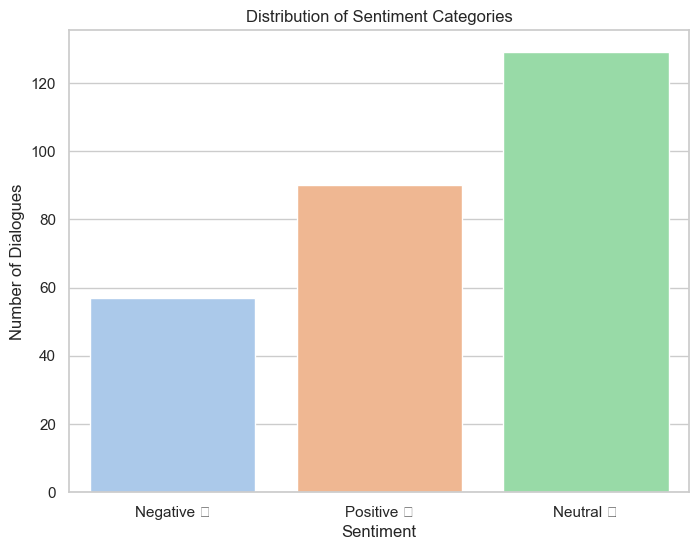

In [54]:
import warnings
warnings.filterwarnings('ignore')


sns.set(style="whitegrid")

# Summary statistics of the Compound Sentiment Scores
print("\nSummary Statistics of Compound Sentiment Scores:")
print(sentiment_dialogues_df['Compound Score'].describe())

# Simple bar chart showing the count of each sentiment category
plt.figure(figsize=(8,6))
sns.countplot(x='Sentiment', data=sentiment_dialogues_df, palette='pastel')
plt.title('Distribution of Sentiment Categories')
plt.xlabel('Sentiment')
plt.ylabel('Number of Dialogues')

filename = 'average_sentiment_distribution.png'
filepath = os.path.join(output_viz_path,filename)
plt.savefig(filepath,dpi=300,bbox_inches='tight')

plt.show()
plt.close()


Average Sentiment by Character Role:
          Role  Compound Score
0   Antagonist        0.039946
1  Protagonist        0.081694
2   Supporting        0.062825


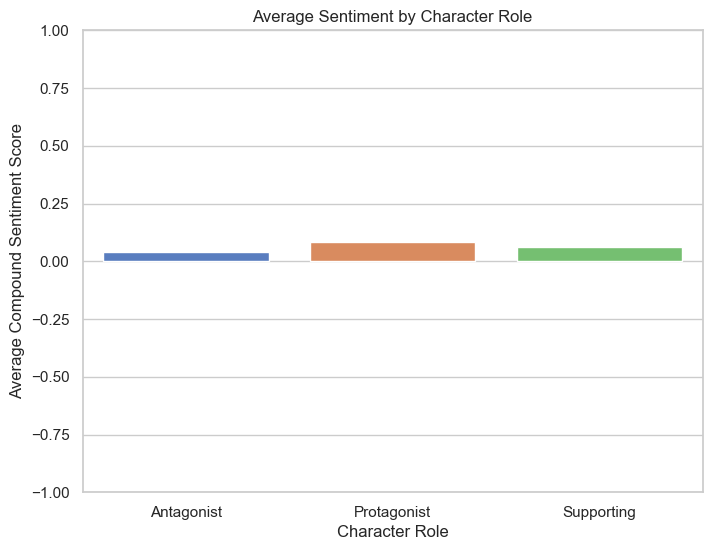

In [55]:
# Calculate average sentiment for each role
role_sentiment = sentiment_dialogues_df.groupby('Role')['Compound Score'].mean().reset_index()

# Display the average sentiment by role
print("\nAverage Sentiment by Character Role:")
print(role_sentiment)

# Bar chart to compare average sentiment across roles
plt.figure(figsize=(8,6))
sns.barplot(x='Role', y='Compound Score', data=role_sentiment, palette='muted')
plt.title('Average Sentiment by Character Role')
plt.xlabel('Character Role')
plt.ylabel('Average Compound Sentiment Score')
plt.ylim(-1, 1)  # VADER scores range from -1 to 1

filename = 'average_sentiment_by_char_role.png'
filepath = os.path.join(output_viz_path,filename)
plt.savefig(filepath,dpi=300,bbox_inches='tight')

plt.show()
plt.close()


Average Sentiment by Marginalized Status:
   Marginalized  Compound Score
0         False        0.058601
1          True        0.081694


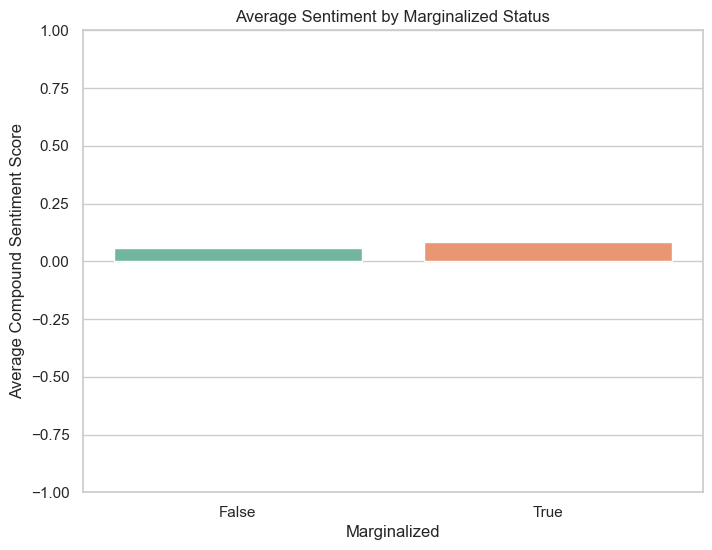

In [58]:
# Calculate average sentiment based on Marginalized status
marginalized_sentiment = sentiment_dialogues_df.groupby('Marginalized')['Compound Score'].mean().reset_index()

# Display the results
print("\nAverage Sentiment by Marginalized Status:")
print(marginalized_sentiment)

# Bar chart to compare average sentiment
plt.figure(figsize=(8,6))
sns.barplot(x='Marginalized', y='Compound Score', data=marginalized_sentiment, palette='Set2')
plt.title('Average Sentiment by Marginalized Status')
plt.xlabel('Marginalized')
plt.ylabel('Average Compound Sentiment Score')
plt.ylim(-1, 1)
filename = 'average_sentiment_by_marginalized_status.png'
filepath = os.path.join(output_viz_path,filename)
plt.savefig(filepath,dpi=300,bbox_inches='tight')

plt.show()
plt.close()


Average Sentiment by POC Status:
     POC  Compound Score
0  False        0.039946
1   True        0.073757


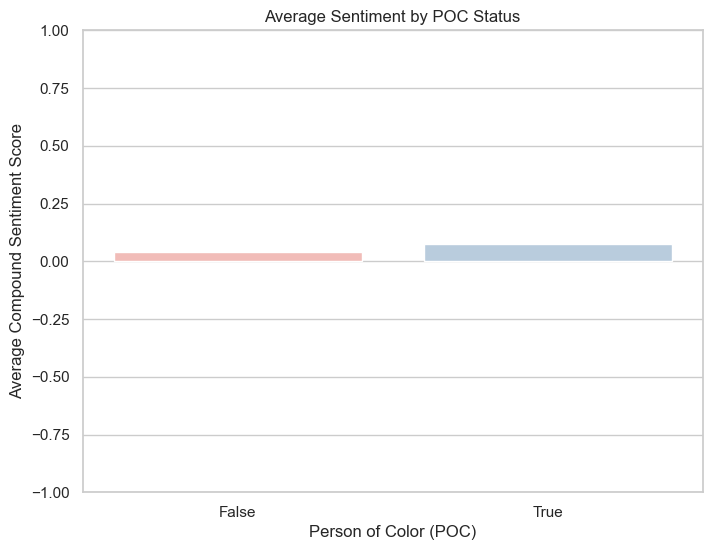

In [59]:
# Calculate average sentiment based on POC status
poc_sentiment = sentiment_dialogues_df.groupby('POC')['Compound Score'].mean().reset_index()

# Display the results
print("\nAverage Sentiment by POC Status:")
print(poc_sentiment)

# Bar chart to compare average sentiment
plt.figure(figsize=(8,6))
sns.barplot(x='POC', y='Compound Score', data=poc_sentiment, palette='Pastel1')
plt.title('Average Sentiment by POC Status')
plt.xlabel('Person of Color (POC)')
plt.ylabel('Average Compound Sentiment Score')
plt.ylim(-1, 1)
filename = 'average_sentiment_by_POC.png'
filepath = os.path.join(output_viz_path,filename)
plt.savefig(filepath,dpi=300,bbox_inches='tight')

plt.show()
plt.close()

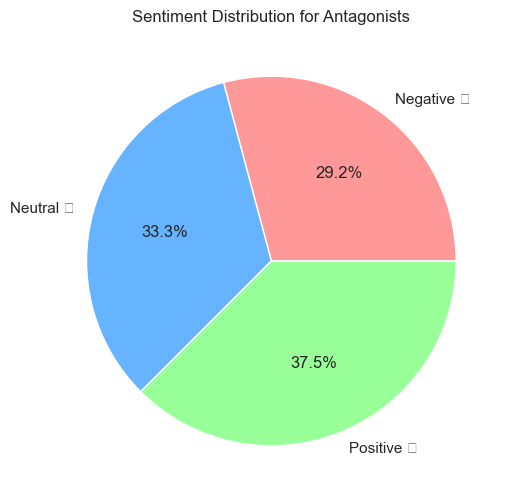

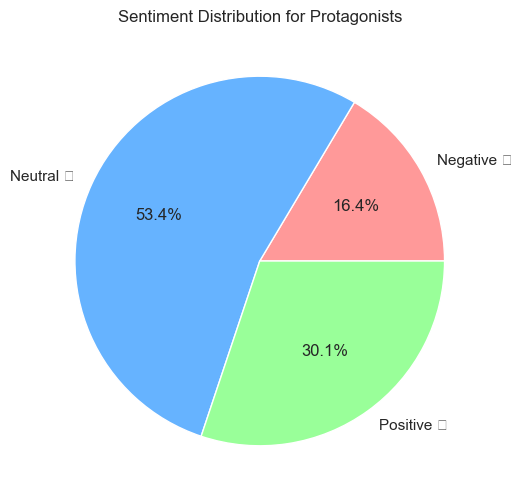

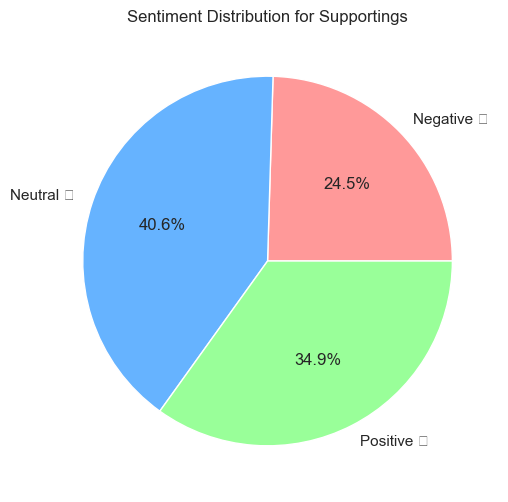

In [60]:
# Calculate sentiment distribution by role
role_sentiment_counts = sentiment_dialogues_df.groupby(['Role', 'Sentiment']).size().reset_index(name='Counts')

# Function to plot pie chart for a given role
def plot_pie(role):
    role_data = role_sentiment_counts[role_sentiment_counts['Role'] == role]
    plt.figure(figsize=(6,6))
    plt.pie(role_data['Counts'], labels=role_data['Sentiment'], autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99'])
    plt.title(f'Sentiment Distribution for {role}s')
    filename = f'sentiment_distribution_for_{role.lower()}.png'
    filepath = os.path.join(output_viz_path,filename)
    plt.savefig(filepath,dpi=300,bbox_inches='tight')
    plt.show()
    plt.close()
# Plot pie charts for each role
plot_pie('Antagonist')
plot_pie('Protagonist')
plot_pie('Supporting')

In [61]:
# Create a crosstab to count sentiments by Role and Marginalized status
pivot_marginalized = pd.crosstab(
    index=[sentiment_dialogues_df['Role'], sentiment_dialogues_df['Marginalized']],
    columns=sentiment_dialogues_df['Sentiment']
).fillna(0)

# Display the pivot table
print("\nCrosstab of Sentiments by Role and Marginalized Status:")
pivot_marginalized


Crosstab of Sentiments by Role and Marginalized Status:


,Sentiment,Negative 😡,Neutral 😐,Positive 😊
Role,Marginalized,,,
Antagonist,False,7,8,9
Protagonist,True,24,78,44
Supporting,False,26,43,37


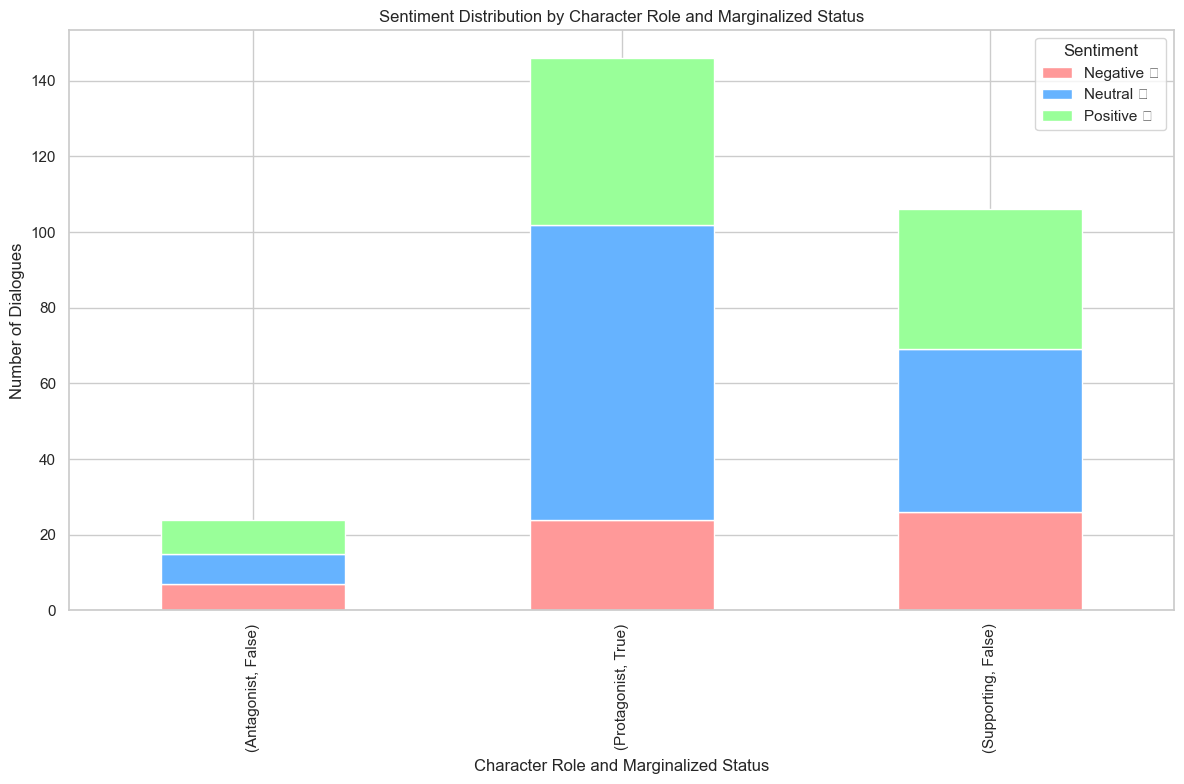

In [62]:
# Reset index to turn MultiIndex into columns
pivot_marginalized_reset = pivot_marginalized.reset_index()

# Rename columns for clarity
pivot_marginalized_reset.columns.name = None
pivot_marginalized_reset = pivot_marginalized_reset.rename(columns={
    'Role': 'Character Role',
    'Marginalized': 'Marginalized Status'
})

# Plotting
pivot_marginalized_reset.set_index(['Character Role', 'Marginalized Status']).plot(
    kind='bar',
    stacked=True,
    figsize=(12, 8),
    color=['#ff9999','#66b3ff','#99ff99']
)

plt.title('Sentiment Distribution by Character Role and Marginalized Status')
plt.xlabel('Character Role and Marginalized Status')
plt.ylabel('Number of Dialogues')
plt.legend(title='Sentiment')
plt.tight_layout()
filename = 'sentiment_distribution_charrole_and_marg_status.png'
filepath = os.path.join(output_viz_path,filename)
plt.savefig(filepath,dpi=300,bbox_inches='tight')
plt.show()


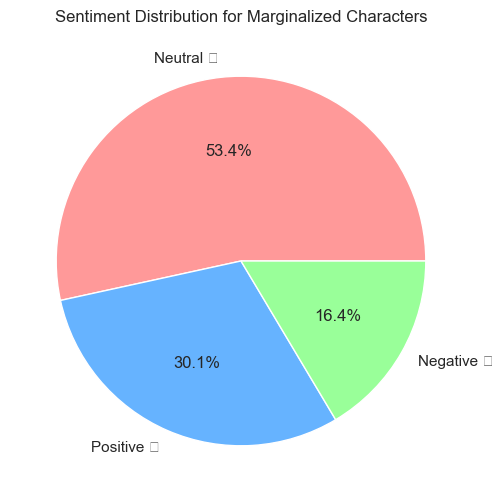

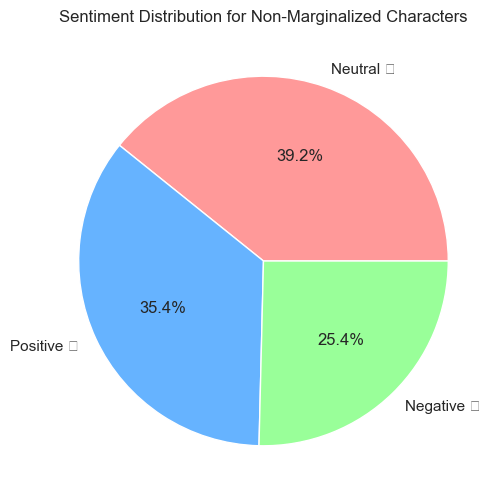

In [63]:
# Define a function to plot pie charts
def plot_pie(data, title, filename,output_path):
    sentiment_counts = data['Sentiment'].value_counts()
    plt.figure(figsize=(6,6))
    plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99'])
    plt.title(title)

    filepath= os.path.join(output_path,filename)
    plt.savefig(filepath,dpi=300,bbox_inches='tight')
    plt.show()
    

# Plot pie chart for Marginalized Characters
marginalized_data = sentiment_dialogues_df[sentiment_dialogues_df['Marginalized'] == True]
plot_pie(marginalized_data, 'Sentiment Distribution for Marginalized Characters','sentiment_distribution_marg_chars.png',output_viz_path)

# Plot pie chart for Non-Marginalized Characters
non_marginalized_data = sentiment_dialogues_df[sentiment_dialogues_df['Marginalized'] == False]
plot_pie(non_marginalized_data, 'Sentiment Distribution for Non-Marginalized Characters','sentiment_distribution_non_marg_chars.png',output_viz_path)

In [64]:
gender_counts = sentiment_dialogues_df['Gender'].value_counts().reset_index()
gender_counts.columns = ["Gender","Dialogue Count"]
gender_counts.head()

,Gender,Dialogue Count
0,Female,170
1,Male,106


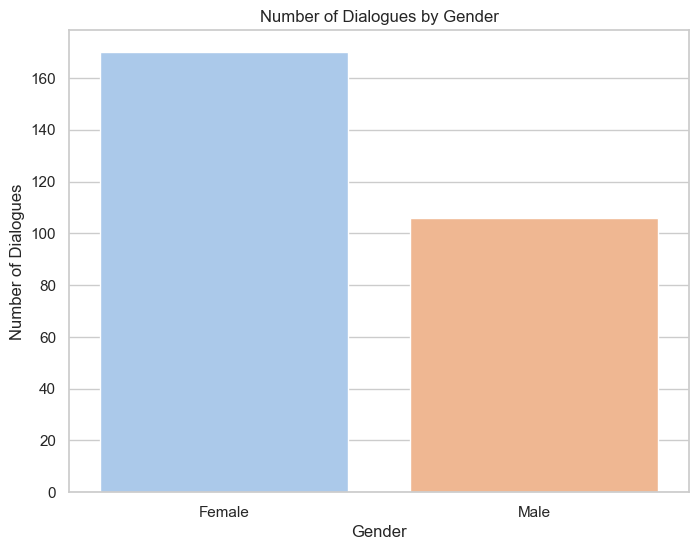

In [65]:
# Plotting Dialogue Counts by Gender
plt.figure(figsize=(8,6))
sns.barplot(x='Gender', y='Dialogue Count', data=gender_counts, palette='pastel')
plt.title('Number of Dialogues by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Dialogues')
filename='dialogue_distribution_by_gender.png'
filepath=os.path.join(output_viz_path,filename)
plt.savefig(filepath,dpi=300,bbox_inches='tight')
plt.show()
plt.close()

In [66]:
# Calculate sentiment distribution by gender
gender_sentiment_counts = sentiment_dialogues_df.groupby(['Gender', 'Sentiment']).size().reset_index(name='Counts')

gender_sentiment_counts

,Gender,Sentiment,Counts
0,Female,Negative 😡,28
1,Female,Neutral 😐,86
2,Female,Positive 😊,56
3,Male,Negative 😡,29
4,Male,Neutral 😐,43
5,Male,Positive 😊,34


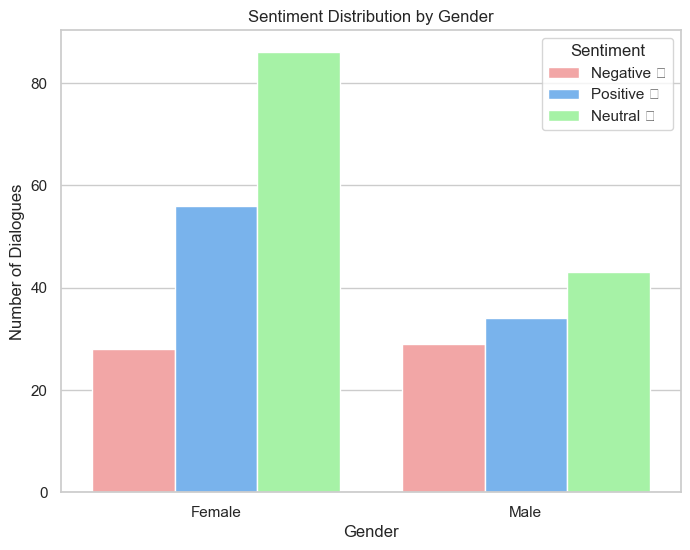

In [67]:
# Plotting Sentiment Distribution by Gender
plt.figure(figsize=(8,6))
sns.countplot(x='Gender', hue='Sentiment', data=sentiment_dialogues_df, palette=['#ff9999','#66b3ff','#99ff99'])
plt.title('Sentiment Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Dialogues')
plt.legend(title='Sentiment')
filename='sentiment_distribution_by_gender.png'
filepath=os.path.join(output_viz_path,filename)
plt.savefig(filepath,dpi=300,bbox_inches='tight')
plt.show()
plt.close()

In [68]:
# Calculate average sentiment score by gender
gender_avg_sentiment = sentiment_dialogues_df.groupby('Gender')['Compound Score'].mean().reset_index()

gender_avg_sentiment

,Gender,Compound Score
0,Female,0.094565
1,Male,0.032729


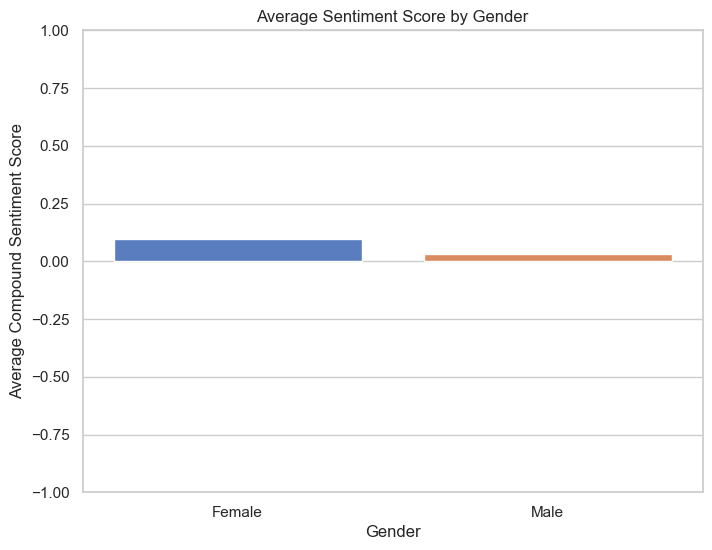

In [69]:
# Plotting Average Sentiment Score by Gender
plt.figure(figsize=(8,6))
sns.barplot(x='Gender', y='Compound Score', data=gender_avg_sentiment, palette='muted')
plt.title('Average Sentiment Score by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Compound Sentiment Score')
plt.ylim(-1, 1)  # VADER scores range from -1 to 1

filename='average_sentiment_score_by_gender.png'
filepath=os.path.join(output_viz_path,filename)
plt.savefig(filepath,dpi=300,bbox_inches='tight')
plt.show()
plt.close()

In [70]:
# Create a new column with descriptive labels for POC status
sentiment_dialogues_df['POC_Status'] = sentiment_dialogues_df['POC'].map({True: 'POC', False: 'Non-POC'})

# Verify the mapping
sentiment_dialogues_df[['Gender', 'POC', 'POC_Status']].sample(6)

,Gender,POC,POC_Status
35,Female,True,POC
24,Male,False,Non-POC
27,Female,True,POC
235,Female,True,POC
164,Female,True,POC
103,Male,True,POC


In [71]:
# Recalculate sentiment distribution using POC_Status
gender_poc_sentiment = sentiment_dialogues_df.groupby(['Gender', 'POC_Status', 'Sentiment']).size().reset_index(name='Counts')

# Display the updated grouped data
gender_poc_sentiment

,Gender,POC_Status,Sentiment,Counts
0,Female,POC,Negative 😡,28
1,Female,POC,Neutral 😐,86
2,Female,POC,Positive 😊,56
3,Male,Non-POC,Negative 😡,7
4,Male,Non-POC,Neutral 😐,8
5,Male,Non-POC,Positive 😊,9
6,Male,POC,Negative 😡,22
7,Male,POC,Neutral 😐,35
8,Male,POC,Positive 😊,25


In [72]:
# Pivot the data for stacked bar plot
pivot_gender_poc = gender_poc_sentiment.pivot_table(
    index=['Gender', 'POC_Status'],
    columns='Sentiment',
    values='Counts',
    fill_value=0
).reset_index()

pivot_gender_poc

Sentiment,Gender,POC_Status,Negative 😡,Neutral 😐,Positive 😊
0,Female,POC,28.0,86.0,56.0
1,Male,Non-POC,7.0,8.0,9.0
2,Male,POC,22.0,35.0,25.0


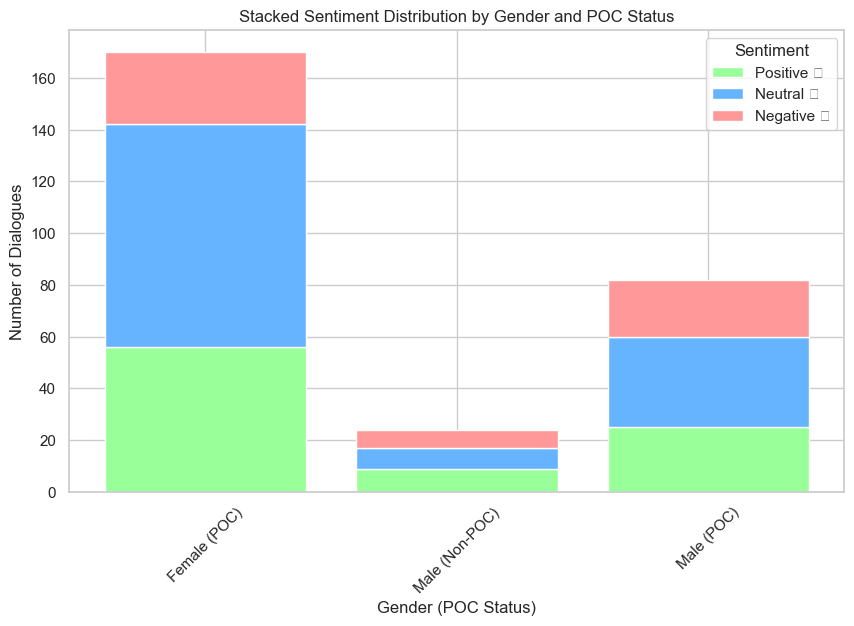

In [73]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Initialize the bottom position for stacking
bottom = None

# Define the sentiments and corresponding colors
sentiments = ['Positive 😊', 'Neutral 😐', 'Negative 😡']
colors = ['#99ff99', '#66b3ff', '#ff9999']

# Loop through sentiments to create stacked bars
for i, sentiment in enumerate(sentiments):
    if i == 0:
        plt.bar(
            pivot_gender_poc['Gender'] + ' (' + pivot_gender_poc['POC_Status'] + ')',
            pivot_gender_poc[sentiment],
            color=colors[i],
            label=sentiment
        )
        bottom = pivot_gender_poc[sentiment]
    else:
        plt.bar(
            pivot_gender_poc['Gender'] + ' (' + pivot_gender_poc['POC_Status'] + ')',
            pivot_gender_poc[sentiment],
            bottom=bottom,
            color=colors[i],
            label=sentiment
        )
        bottom += pivot_gender_poc[sentiment]

# Add title and labels
plt.title('Stacked Sentiment Distribution by Gender and POC Status')
plt.xlabel('Gender (POC Status)')
plt.ylabel('Number of Dialogues')
plt.legend(title='Sentiment')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Save the plot
#plt.savefig(os.path.join(output_folder, 'stacked_bar_charts', 'stacked_sentiment_distribution_by_gender_poc.png'), dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# Close the plot to free memory
plt.close()

In [74]:
# Create a combined category for POC and Marginalized Status
sentiment_dialogues_df['POC_Marginalized'] = sentiment_dialogues_df.apply(
    lambda row: 'POC & Marginalized' if row['POC_Status'] == 'POC' and row['Marginalized'] else
                'POC & Non-Marginalized' if row['POC_Status'] == 'POC' and not row['Marginalized'] else
                'Non-POC & Marginalized' if row['POC_Status'] == 'Non-POC' and row['Marginalized'] else
                'Non-POC & Non-Marginalized',
    axis=1
)

# Display the updated DataFrame
sentiment_dialogues_df[['Gender', 'POC_Marginalized', 'Sentiment']].head()

,Gender,POC_Marginalized,Sentiment
0,Female,POC & Non-Marginalized,Negative 😡
1,Female,POC & Non-Marginalized,Positive 😊
2,Female,POC & Non-Marginalized,Positive 😊
3,Female,POC & Marginalized,Negative 😡
4,Female,POC & Marginalized,Negative 😡


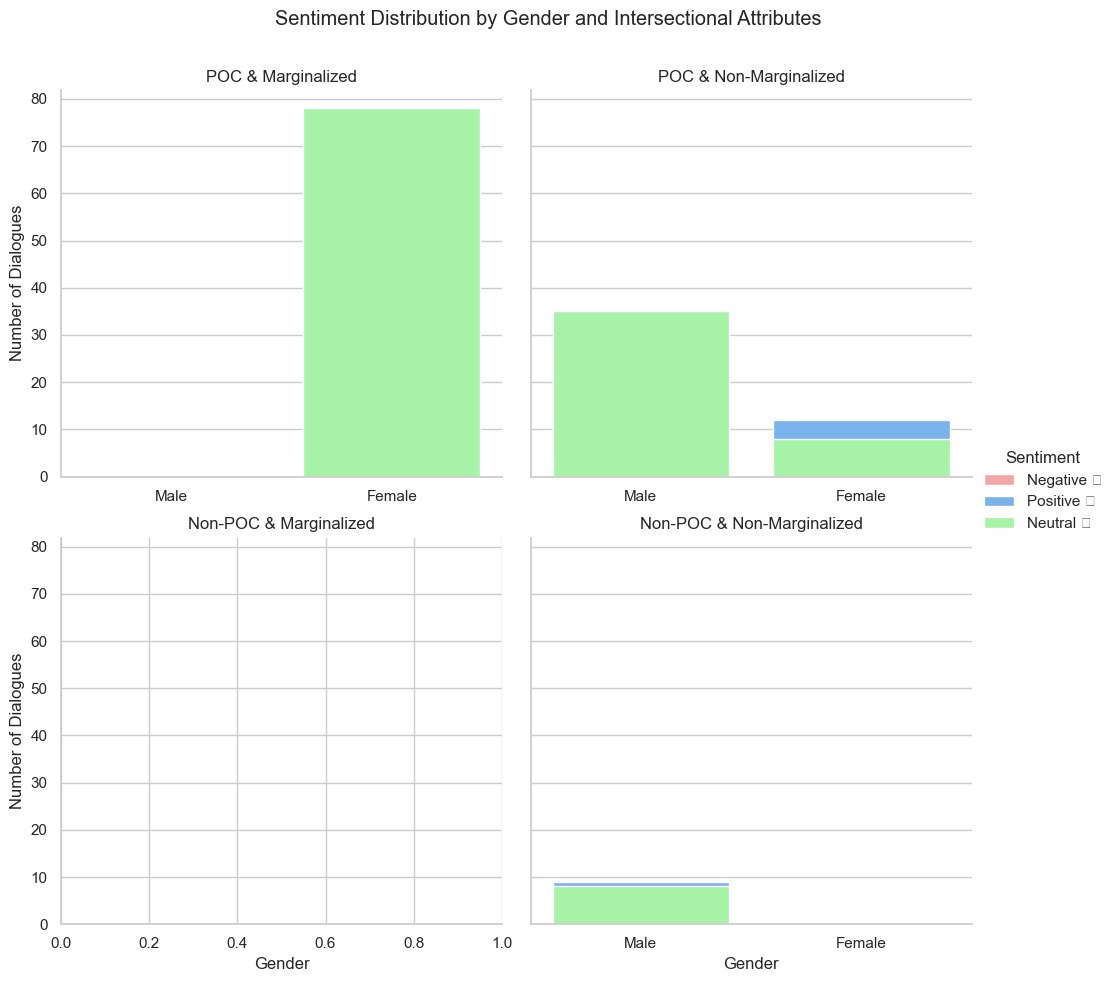

In [75]:
# Define all possible categories for POC_Marginalized
categories = [
    'POC & Marginalized',
    'POC & Non-Marginalized',
    'Non-POC & Marginalized',
    'Non-POC & Non-Marginalized'
]

# Update the 'POC_Marginalized' column with categorical type
sentiment_dialogues_df['POC_Marginalized'] = pd.Categorical(
    sentiment_dialogues_df['POC_Marginalized'],
    categories=categories
)

# Recreate the FacetGrid with the defined categories
g = sns.FacetGrid(
    sentiment_dialogues_df,
    col='POC_Marginalized',
    hue='Sentiment',
    col_wrap=2,
    height=5,
    palette=['#ff9999','#66b3ff','#99ff99'],
    sharex=False
)

g.map(sns.countplot, 'Gender', order=['Male', 'Female'])

# Add legend and titles
g.add_legend(title='Sentiment')
g.set_axis_labels('Gender', 'Number of Dialogues')
g.set_titles("{col_name}")

# Adjust the layout and add a main title
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Sentiment Distribution by Gender and Intersectional Attributes')

# Save the FacetGrid plot
#g.savefig(os.path.join(output_folder, 'bar_charts', 'sentiment_distribution_facetgrid_complete.png'), dpi=300, bbox_inches='tight')
filename = 'sentiment_distribution_facetgrid_complete.png'
filepath = os.path.join(output_viz_path,filename)
plt.savefig(filepath, dpi=300,bbox_inches='tight')

# Display the plot
plt.show()

# Close the plot to free memory
plt.close()

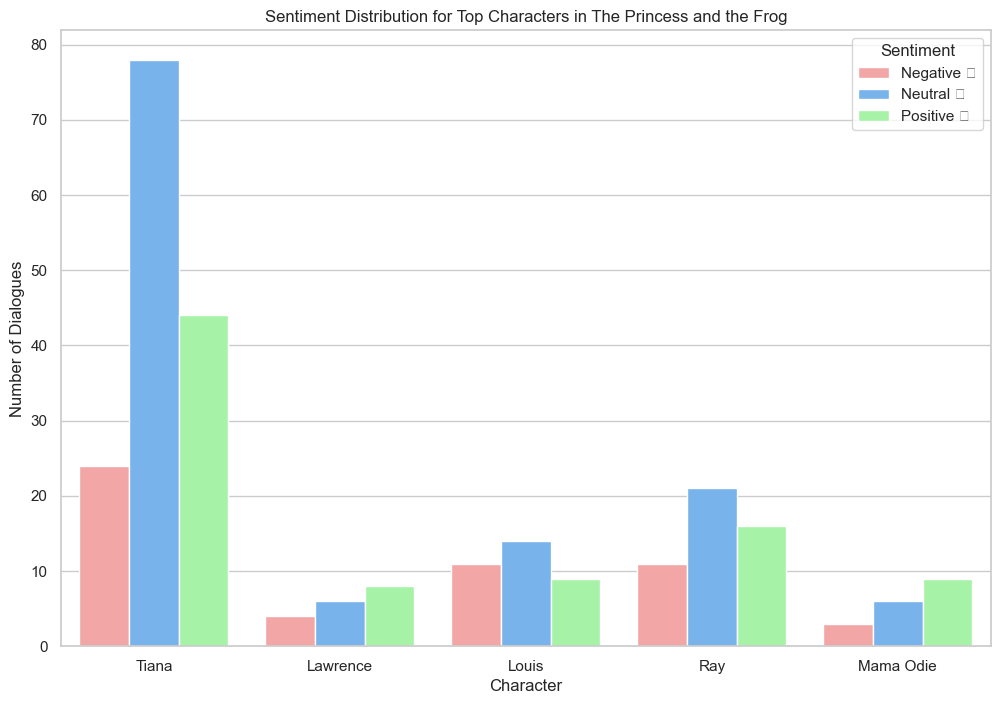

In [77]:
# Identify top 5 characters by dialogue count
top_characters = sentiment_dialogues_df['Character'].value_counts().head(5).index.tolist()

# Filter data for top characters
top_characters_data = sentiment_dialogues_df[sentiment_dialogues_df['Character'].isin(top_characters)]

# Plot sentiment distribution for top characters
plt.figure(figsize=(12, 8))
sns.countplot(x='Character', hue='Sentiment', data=top_characters_data, palette=['#ff9999','#66b3ff','#99ff99'])
plt.title('Sentiment Distribution for Top Characters in The Princess and the Frog')
plt.xlabel('Character')
plt.ylabel('Number of Dialogues')
plt.legend(title='Sentiment')
filename = 'sentiment_distribution_top_characters.png'
filepath = os.path.join(output_viz_path,filename)
plt.savefig(filepath, dpi=300,bbox_inches='tight')
plt.show()
plt.close()